In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [2]:
eth_price_raw = pd.read_csv('ethereum_price.csv')

In [3]:
# set df to manipulate
eth_price = eth_price_raw[['Date', 'Close']].copy()

# convert date to datetime
eth_price['Date'] = pd.to_datetime(eth_price['Date'], format='%b %d, %Y')
eth_price.sort_values('Date', inplace=True)
eth_price.reset_index(drop=True, inplace=True)
print(eth_price.shape)
eth_price.head()

(929, 2)


,Date,Close
0,2015-08-07,2.770000
1,2015-08-08,0.753325
2,2015-08-09,0.701897
3,2015-08-10,0.708448
4,2015-08-11,1.070000


In [4]:
print(eth_price.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 0 to 928
Data columns (total 2 columns):
Date     929 non-null datetime64[ns]
Close    929 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.6 KB
None


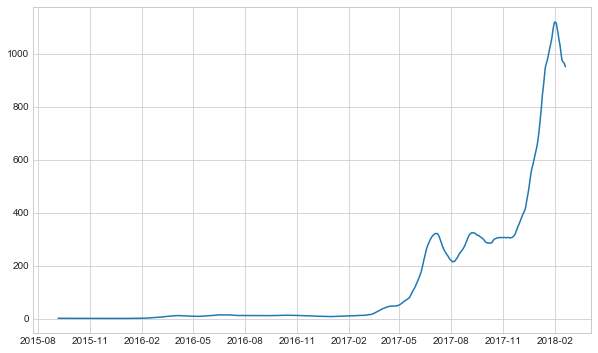

In [14]:
plt.figure(figsize=(10,6))
plt.plot(eth_price['Date'], eth_price['Close'].rolling(30).mean())
plt.show()

Breakpoint looks to be somewhere around 2017-03, but isolate range to test

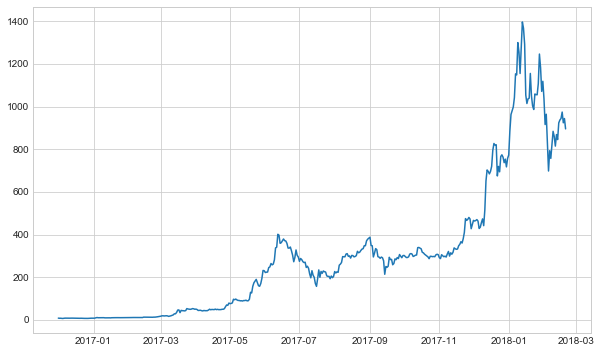

In [6]:
plt.figure(figsize=(10,6))
plt.plot(eth_price['Date'].loc[eth_price['Date'] >= '2016-12-01'],
         eth_price['Close'].loc[eth_price['Date'] >= '2016-12-01'])
plt.show()

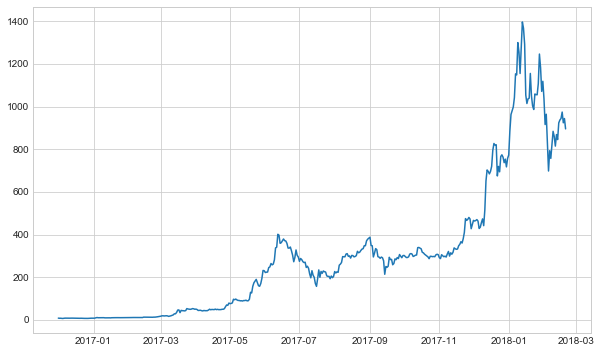

(447, 2)


In [7]:
break_date_range = eth_price.loc[
    eth_price['Date'] >= '2016-12-01']

#break_date_range = break_date_range.loc[
#    break_date_range['Date'] <= '2017-04-01']

plt.figure(figsize=(10,6))
plt.plot(break_date_range['Date'], break_date_range['Close'])
plt.show()

print(break_date_range.shape)

In [8]:
possible_breakpoints = []

#for i, r in break_date_range.iterrows():
#    possible_breakpoints.append(i)

for i, r in eth_price[1:].iterrows():
    possible_breakpoints.append(i)

print(len(eth_price), len(possible_breakpoints))
#print(possible_breakpoints[:5])

929 928


## Chow break test
**Test of whether the true coefficients in two linear regressions on different data sets are equal**

**Null hypothesis**: there is no breakpoint

1. Run regression for entire dataset & collect error sum of squares data
2. Run regression on each half of the dataset & collect error sum of squares data for each

$$RSS=\sum_{i=1}^n(y_i-f(x_i))^2$$

3. Calculate Chow F statistic using SSE from each subsample
4. Find F-critical value from F-Table & reject null hypothesis if calculated F-value falls in rejection range

$$CHOW=\frac{(RSS_p-(RSS_1+RSS_2))/k}{(RSS_1+RSS_2)/(N_1+N_2-2k)}$$

- $RSS_p, RSS_1, RSS_2=$ residual sum of squares for linear regressions for pooled, before & after break point
- $k=$ number of breakpoints
- $N_1, N_2=$ number of datapoints in $RSS_1, RSS_2$

928 928


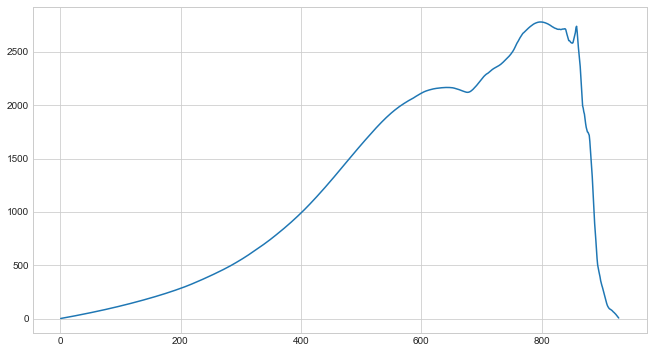

In [12]:
from sklearn import linear_model
# chow f values
# rss_p
X = np.array(eth_price['Date'].map(dt.datetime.toordinal)).reshape(-1,1)
y = np.array(eth_price['Close']).reshape(-1,1)

# fit model and calculate rss
lm_p = linear_model.LinearRegression().fit(X,y)
rss_p = np.sum(np.square(y - lm_p.predict(X)))

k = 1
chow_flist = []

for point in possible_breakpoints:
    
    # rss_1
    X_1 = np.array(eth_price['Date'][:point].map(dt.datetime.toordinal)).reshape(-1,1)
    y_1 = np.array(eth_price['Close'][:point]).reshape(-1,1)
    lm_1 = linear_model.LinearRegression().fit(X_1, y_1)
    rss_1 = np.sum(np.square(y_1 - lm_1.predict(X_1)))
    
    # rss_2
    X_2 = np.array(eth_price['Date'][point:].map(dt.datetime.toordinal)).reshape(-1,1)
    y_2 = np.array(eth_price['Close'][point:]).reshape(-1,1)
    lm_2 = linear_model.LinearRegression().fit(X_2, y_2)
    rss_2 = np.sum(np.square(y_2 - lm_2.predict(X_2)))
    
    # chow
    n_1, n_2 = len(X_1), len(X_2)
    chow = ((rss_p - (rss_1 + rss_2)) / k) / ((rss_1 + rss_2) / (n_1 + n_2 - 2*k))
    chow_flist.append(chow)

print(len(possible_breakpoints), len(chow_flist))

plt.figure(figsize=(11,6))
plt.plot(possible_breakpoints, chow_flist)
plt.show()

In [ ]:
# chow p values

degrees_of_freedom = 1
alpha = .05

In [ ]:
from sklearn import linear_model

# rss_p
X = np.array(eth_price['Date'].map(dt.datetime.toordinal)).reshape(-1,1)
y = np.array(eth_price['Close']).reshape(-1,1)

# fit model and calculate rss
lm_p = linear_model.LinearRegression().fit(X,y)
rss_p = np.sum(np.square(y - lm_p.predict(X)))

# rss_1
X_1 = np.array(eth_price['Date'][:possible_breakpoints[0]].map(dt.datetime.toordinal)).reshape(-1,1)
y_1 = np.array(eth_price['Close'][:possible_breakpoints[0]]).reshape(-1,1)

# fit model and calculate rss
lm_1 = linear_model.LinearRegression().fit(X_1, y_1)
rss_1 = np.sum(np.square(y_1 - lm_1.predict(X_1)))

# rss_2
X_2 = np.array(eth_price['Date'][possible_breakpoints[0]:].map(dt.datetime.toordinal)).reshape(-1,1)
y_2 = np.array(eth_price['Close'][possible_breakpoints[0]:]).reshape(-1,1)

lm_2 = linear_model.LinearRegression().fit(X_2, y_2)
rss_2 = np.sum(np.square(y_2 - lm_2.predict(X_2)))

# set k, n_1, n_2
k, n_1, n_2 = 1, len(X_1), len(X_2)

# calculate chow
chow = ((rss_p - (rss_1 + rss_2)) / k) / ((rss_1 + rss_2) / (n_1 + n_2 - 2*k))
print(chow)

### From previous challenge notebook:

In [ ]:
# try splitting the time series around 2017-05
# which is where price movement begins to take off

eth_price2 = eth_price_raw[['Date', 'Close']].copy()
eth_price2['Date'] = pd.to_datetime(eth_price2['Date'], format='%b %d, %Y')
eth_price2 = eth_price2.loc[eth_price2['Date'] >= '2017-05-01']

print(eth_price.shape)
print(eth_price2.shape)

In [ ]:
plt.figure(figsize=(11,6))
plt.plot(eth_price2['Date'], eth_price2['Close'])
plt.show()

In [ ]:
eth_price2['diff_1'] = eth_price2.Close - eth_price2.Close.shift()

plt.figure(figsize=(11,6))
plt.plot(eth_price2['Date'], eth_price2['diff_1'])
plt.title('close price after 2017-05, diff_1')
plt.show()

print('adf: {0}\npval: {1}\ncritical vals {2}'.format(
    adfuller(eth_price2['diff_1'][1:])[0],
    adfuller(eth_price2['diff_1'][1:])[1],
    adfuller(eth_price2['diff_1'][1:])[4]))

In [ ]:
eth_price2['log_return'] = (np.log(eth_price2.Close)
                        - np.log(eth_price2.Close.shift(1)))

plt.figure(figsize=(11,6))
plt.plot(eth_price2['Date'], eth_price2['log_return'])
plt.title('close price after 2017-05 log return')
plt.show()

print('adf: {0}\npval: {1}\ncritical vals {2}'.format(
    adfuller(eth_price2['log_return'][2:])[0],
    adfuller(eth_price2['log_return'][2:])[1],
    adfuller(eth_price2['log_return'][2:])[4]))